### Conversation Q&A Chatbot
In many Q&A applications we want to allow the user to have a back-and-forth conversation, meaning the application needs some sort of "memory" of past questions and answers, and some logic for incorporating those into its current thinking.

In this guide we focus on adding logic for incorporating historical messages. Further details on chat history management is covered in the previous sessions.

We will cover two approaches:

- Chains, in which we always execute a retrieval step;
- Agents, in which we give an LLM discretion over whether and how to execute a retrieval step (or multiple steps).

In [1]:
import sys
sys.prefix

'c:\\Users\\Admin\\Documents\\GEN_AI\\Langchain\\4-QAChatbot_MsgHistory\\.venv'

In [2]:
!pip list

Package                                  Version
---------------------------------------- -----------
aiohappyeyeballs                         2.4.3
aiohttp                                  3.11.6
aiosignal                                1.3.1
annotated-types                          0.7.0
anyio                                    4.6.2.post1
asgiref                                  3.8.1
asttokens                                2.4.1
attrs                                    24.2.0
backoff                                  2.2.1
bcrypt                                   4.2.1
beautifulsoup4                           4.12.3
bs4                                      0.0.2
build                                    1.2.2.post1
cachetools                               5.5.0
certifi                                  2024.8.30
charset-normalizer                       3.4.0
chroma-hnswlib                           0.7.6
chromadb                                 0.5.20
click                           


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

Fetching the Groq API key and storing in a variable

In [4]:
groq_api_key = os.getenv('GROQ_API_KEY')
groq_api_key

'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'

Creating an instance of the LLM model 'llama3-8b-8192'

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(model='llama3-8b-8192' , api_key=groq_api_key)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000207F7007D90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000207F70AF290>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

Install bs4 as its the dependency for using WebBaseLoader for scrapping data from web pages

- bs4 is mentioned in the requirements.txt

Create an instance of the embedding model that is accessed from HuggingFace

In [6]:
os.environ['HF_TOKEN']=os.getenv('HF_TOKEN')

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
embeddings

c:\Users\Admin\Documents\GEN_AI\Langchain\4-QAChatbot_MsgHistory\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

Import libraries for creating a RAG pipeline

In [8]:
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

USER_AGENT environment variable not set, consider setting it to identify your requests.


Step 1 -  Load, chunk and index the contents of the blog to create a retriever.

- Loading the data using WebBaseLoader

Documentation - https://python.langchain.com/docs/integrations/document_loaders/web_base/

In [9]:
import bs4
loader = WebBaseLoader(web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
              bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),)

docs = loader.load()

In [10]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

Splitting the documents using RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
splits = text_splitter.split_documents(docs)

### Converting the documents to vectors using embedding model and storing them in vector store

vectorstore = Chroma.from_documents(documents=splits , embedding=embeddings)

### Create a retriever

retriever = vectorstore.as_retriever()

retriever
 

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000207A56250D0>, search_kwargs={})

Creating a Prompt Template. 

- This prompt template will be used to ask query from user along with the context retrived from retriever and passed to LLM to get response

In [12]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

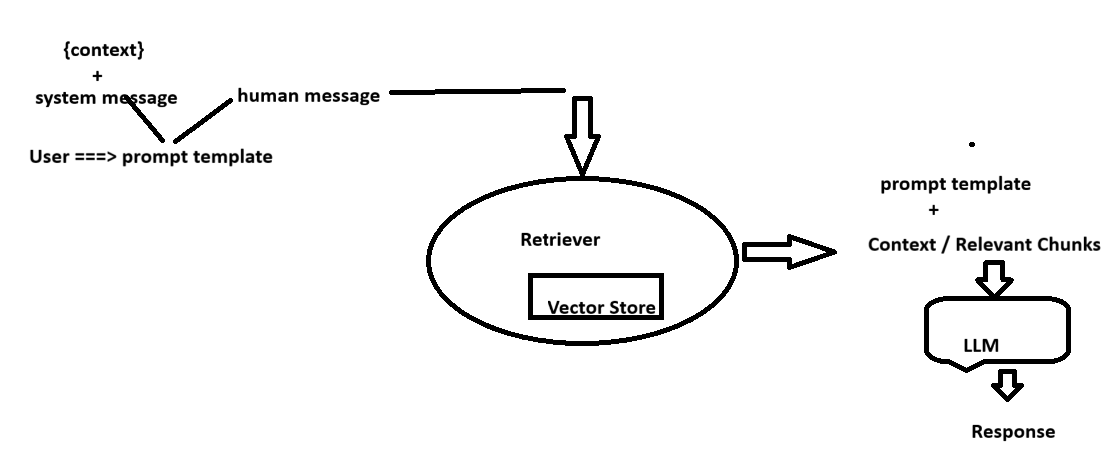

Significance of create_stuff_document_chain

- When a we receive relevant chunks (context) as an output from the retriever, these chunks can be stuffed together to create a summarised context that gets added to the context placeholder in the prompt template. Later the prompt template (system message + context , human message / query) acts as input to LLM to give response

In [13]:
question_answer_chain = create_stuff_documents_chain(llm = llm,prompt = prompt)

In [14]:
rag_chain = create_retrieval_chain(retriever,question_answer_chain)

In [15]:
response = rag_chain.invoke({'input' : 'What is Self-Reflection?'})
response

{'input': 'What is Self-Reflection?',
 'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 3. Illustration of the Reflexion framework. (Image source: Shinn & Labash, 2023)\nThe heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.\nSelf-reflection is created by showing two-shot examples to LLM and each example is a pair of (failed trajectory, ideal reflection for guiding future changes in the plan). Then reflections are added into the agent’s working memory, up to three, to be used as context for querying LLM.'),
  Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Memory stream: is a long-term memor

In [16]:
### Final Response from LLM
print(response['answer'])

Self-reflection is a mechanism that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It helps agents to learn from their experiences and make better decisions in the future.


Now if we ask a new question in continuation to above conversation the ideal expectation from the user is that the chat model would provide relevant response.

However this is not the case since currently message history is not mentained within the RAG application

In [17]:
### Lets ask a question in continuation with above conversation

rag_chain.invoke({'input' : 'What question did I asked earlier?'})

### The below response from LLM is incorrect and not relevant to the question we asked. Hence there is a requirement to preserve Message History for a Q&A Conversational Chat Bot application

{'input': 'What question did I asked earlier?',
 'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='inquired about current trends in anticancer drug discovery;\nselected a target;\nrequested a scaffold targeting these compounds;\nOnce the compound was identified, the model attempted its synthesis.'),
  Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer

In [18]:
### Lets ask a question in continuation with above conversation

response = rag_chain.invoke({"input":"How do we achieve it?"})
print(response['answer'])

### The below response from LLM is incorrect and not relevant to the question we asked. Hence there is a requirement to preserve Message History for a Q&A Conversational Chat Bot application

According to the context, Tree of Thoughts (Yao et al. 2023) achieves task decomposition by first decomposing the problem into multiple thought steps and generating multiple thoughts per step, creating a tree structure. The search process can be done using BFS or DFS with each state evaluated by a classifier or majority vote.


### Scenario 2 - Adding Chat History

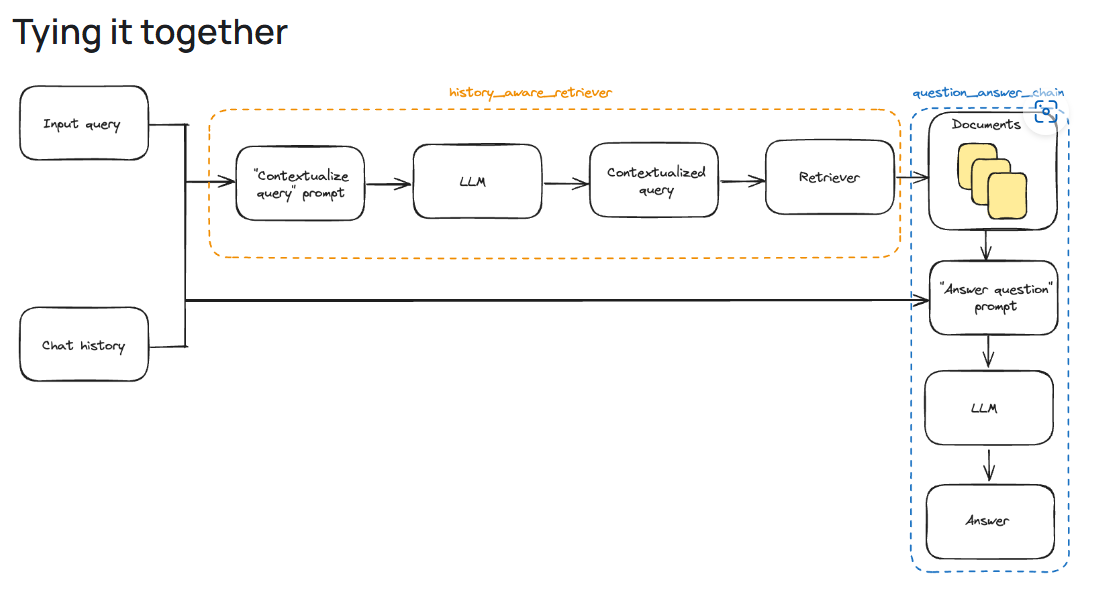

##### create_history_aware_retriever 

Documentation - https://python.langchain.com/api_reference/langchain/chains/langchain.chains.history_aware_retriever.create_history_aware_retriever.html

- Create a chain that takes conversation history and returns documents.

- If there is no chat_history, then the input is just passed directly to the retriever. If there is chat_history, then the prompt and LLM will be used to generate a search query. That search query is then passed to the retriever

- It is an advanced version of create_retrieval_chain where a simple prompt (system message + humman message) is queried against the retriver to get relevant context (chunks). Later these chunks are clubbed together with prompt as input to LLM to get the response

In [19]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

### MessagePlaceHolder - Its a key-value pair where the chat-history will be stored

In [20]:

### Below we have the system prompt that is redesigned so that it takes the user question + chat history (if available) and pass it through the LLM to get the standalone question which can be understood without chat history. But make sure LLM does not answer this question.

### Reference -> https://python.langchain.com/docs/how_to/qa_chat_history_how_to/#prompt


contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)



contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ('system' , contextualize_q_system_prompt),
    MessagesPlaceholder('chat_history'),
    ('human','{input}')
])

In [21]:
history_aware_retriever = create_history_aware_retriever(llm,retriever,contextualize_q_prompt)
history_aware_retriever

RunnableBinding(bound=RunnableBranch(branches=[(RunnableLambda(lambda x: not x.get('chat_history', False)), RunnableLambda(lambda x: x['input'])
| VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000207A56250D0>, search_kwargs={}))], default=ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessag

After the above step once the history_aware retriever provides relevant documents, theses relevant documents are clubbed with the "question answer prompt" i.e. qa_prompt (system prompt + humman message + chat history) and provided as input to LLM to get response

In [22]:
### Design the qa_prompt

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

qa_prompt = ChatPromptTemplate.from_messages(
    [('system' , system_prompt),
    MessagesPlaceholder('chat_history'),
    ('human' , '{input}')]
)

In [ ]:
### Documentation of create stuff document chain ---> https://medium.com/@vinusebastianthomas/document-chains-in-langchain-d33c4bdbabd8

question_answer_chain=create_stuff_documents_chain(llm,qa_prompt)
rag_chain=create_retrieval_chain(history_aware_retriever,question_answer_chain)

In [24]:

question = "What is Self Reflection?"   ### User question
chat_history = [] ### declaring empty list to save chat history

response = rag_chain.invoke({'input' : question , 
                  'chat_history' : chat_history})


In [25]:
response['answer']

'Self-reflection is a mechanism that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It is a crucial aspect of real-world tasks where trial and error are inevitable.'

Once we get the response it needs to be added to the chat history. 

In [26]:
from langchain_core.messages import HumanMessage , AIMessage
chat_history.extend([
    HumanMessage(content=question),
    AIMessage(content=response['answer'])

])

In [27]:
chat_history

[HumanMessage(content='What is Self Reflection?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Self-reflection is a mechanism that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It is a crucial aspect of real-world tasks where trial and error are inevitable.', additional_kwargs={}, response_metadata={})]

In [28]:
question="What I asked earlier?"
response2=rag_chain.invoke({"input":question,"chat_history":chat_history})

In [29]:
response2

{'input': 'What I asked earlier?',
 'chat_history': [HumanMessage(content='What is Self Reflection?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Self-reflection is a mechanism that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It is a crucial aspect of real-world tasks where trial and error are inevitable.', additional_kwargs={}, response_metadata={})],
 'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Here are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructions and not carry them out, only seek to clarify them.\\nSpecifically you will first summarise a list of super short bullets of areas that need clarification.\\nThen you will pick one clarifying quest

In [30]:
question="What is my name?"
response3=rag_chain.invoke({"input":question,"chat_history":chat_history})

In [31]:
response3

{'input': 'What is my name?',
 'chat_history': [HumanMessage(content='What is Self Reflection?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Self-reflection is a mechanism that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It is a crucial aspect of real-world tasks where trial and error are inevitable.', additional_kwargs={}, response_metadata={})],
 'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events hav

### Adding Session Information to Chat History



In [33]:
### Chat message history stores a history of the message interactions in a chat.
from langchain_community.chat_message_histories import ChatMessageHistory

###  Abstract base class for storing chat message history.
from langchain_core.chat_history import BaseChatMessageHistory


### RunnableWithMessageHistory wraps another Runnable and manages the chat message history for it; it is responsible for reading and updating the chat message history
from langchain_core.runnables.history import RunnableWithMessageHistory

In [34]:
store = {}

### function that retrives chat history for a specific session id

def get_session_history(session_id:str)->BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [35]:
conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [36]:
### Now lets ask a question with respect to specific session id 'abc123' passed inside the configuration object


response4 = conversational_rag_chain.invoke(
    {"input": "What is Task Decomposition?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)

response4["answer"]

'Task decomposition is the process of breaking down a complex task into smaller, more manageable subtasks or steps. This technique helps an agent or model to plan and approach a task in a more structured and efficient way.'

In [37]:
### Lets verify if the application remembers the chat history for the specific session if 'abc123'

response5 = conversational_rag_chain.invoke(
    {"input": "What question did I asked?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)

response5["answer"]

'You asked "What is Task Decomposition?"'

In [38]:
### Now lets change the session id to 'def123'

response4 = conversational_rag_chain.invoke(
    {"input": "What question did I asked?"},
    config={
        "configurable": {"session_id": "def123"}
    },  # constructs a key "abc123" in `store`.
)

response4["answer"]

"You didn't ask a question. You provided some context and asked me to use it to answer a question. However, there was no question to answer. Please provide a question, and I'll do my best to answer it."

As we can see from the above response as soon as the session id changes the chat bot is unable to remember the message history